In [29]:
#Imports
import sqlite3
import pandas as pd
import re
import numpy as np 
import sys
import json
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import DBSCAN
from sklearn.pipeline import make_pipeline
import shap 
import seaborn as sns

# Section 1: Data Source and Wrangling
### Data source is the MIMIC-3 database https://physionet.org/content/mimiciii/1.4/

In [2]:
#Helper function from Kolton
def get_col_names(cursor, table_name):
    '''
    Retrieves the column names for a table in a sqlite3 db.
    ------
    cursor: sqliteConnection cursor object
    table_name: table_name to get column names for
    '''
    cursor.execute(f"""
    SELECT sql FROM sqlite_master WHERE name='{table_name}';
    """)
    
    res = mimiciii.fetchall()
    cols = re.findall(r'\"\w+\"', res[0][0])
    return [x[1:-1] for x in cols]

def get_df_from_table_from_db(cursor, table_name, num_rows='*', skip_cols=[]):
    '''
    Retreives table from sqlite3 db in form of df
    ------
    cursor: sqliteConnection cursor object
    table_name: name of table to get from cursor db
    num_rows: number of rows to retrieve (or '*' for all rows)
    skip_cols: list of columns to skip in the retrieval
    '''
    col_names = get_col_names(cursor, table_name)
    
    use_cols = [col for col in col_names if col not in skip_cols]
    
    if num_rows == '*':
        query = f'''select {', '.join(use_cols)} from {table_name};'''
    else:
        query = f'''select {', '.join(use_cols)} from {table_name} limit {num_rows};'''
        
    cursor.execute(query)
    rows = cursor.fetchall()
    
    return pd.DataFrame(rows, columns=use_cols)

def get_tables_list_from_db(cursor):
    cursor.execute("""
    select name from sqlite-master where type='table';
    """)
    table_names = [table[0] for table in cursor.fetchall()]
    return table_names

def to_int(x):
    if not x or np.isnan(x):
        return 0
    return int(x)

## 1-1: Loading data and initial wrangling
#### In 1-1, I mainly read data from multiple tables and merge them into one smaller dataframe for easier process.
#### Alert: The wrangling proceess may take up to hours to run. The following code is just for reference. The wrangled data will be provided.

In [3]:
# #connection object to db
# db_path = 'D:/mimic-iii-clinical-database-1.4/mimic3.db'
# sqliteConnection = sqlite3.connect(db_path)
# #cursor/pointer
# mimiciii = sqliteConnection.cursor()

# #Extract admission table with designated attributes
# admission = get_df_from_table_from_db(mimiciii, 'admissions')
# admission = admission.apply(lambda x: x.astype(str).str.upper())
# admission.HADM_ID = admission.HADM_ID.astype('int64')
# admission.SUBJECT_ID = admission.SUBJECT_ID.astype('int64')

# admission = admission[['HADM_ID','SUBJECT_ID','DIAGNOSIS']]

# #Import json for HADM_ID list of arf diagnosis
# arf_data = []
# with open('arf_hadm_ids.json') as json_file:
#    arf_data = json.load(json_file)
# admission.loc[admission['HADM_ID'].isin(list(map(int, arf_data)))]

# #Mark arf as arf, and the rest as other
# admission['WR_DIAGNOSIS'] = np.full(len(admission),"Other")
# admission.loc[admission['HADM_ID'].isin(list(map(int, arf_data))),'WR_DIAGNOSIS'] = "ARF" 
# admission['WR_DIAGNOSIS'].value_counts()

# # Read the labevents table, which is huge
# labevents = get_df_from_table_from_db(mimiciii, 'labevents')
# labevents = labevents[~np.isnan(labevents['HADM_ID'])]
# labevents.HADM_ID = labevents.HADM_ID.astype('int64')
# labevents.to_csv("temp_labevent.csv",index=False)

# # Read the labitems table for ITEMID-test name mapping
# test_names = get_df_from_table_from_db(mimiciii, 'd_labitems')

# # There are too many tests types and not all of them are performed for a HADM_ID
# # So instead, we pick the most common 10 tests to decrease the number of dropped tests when doing dropna 
# most_common_tests = labevents.groupby('ITEMID').count().sort_values(by='HADM_ID', ascending=False)[0:10]
# most_common_tests = pd.DataFrame({'ITEMID':most_common_tests.index,'COUNT':most_common_tests['HADM_ID']})
# most_common_tests.reset_index(drop=True,inplace=True)
# most_common_tests = most_common_tests.merge(test_names,on='ITEMID',how='left')[['ITEMID','LABEL']]

# # Filter the labevents according to the most common tests
# labevents = labevents[labevents['ITEMID'].isin(most_common_tests['ITEMID'].unique())]

# # Align two tables
# labevents = labevents[labevents['HADM_ID'].isin(admission['HADM_ID'].unique())]
# admission = admission[admission['HADM_ID'].isin(labevents['HADM_ID'].unique())]

# # Make columns for most common tests' values and abnormalities
# import warnings
# warnings.filterwarnings("ignore")
# for name in most_common_tests['LABEL']:
#     admission.loc[:,name] = np.full(len(admission),"")
#     admission.loc[:,name+"_ab"] = np.full(len(admission),False)
    
# # Collect values form labevents and fill them into admission dataframe
# for id in admission['HADM_ID']:
#     temp = labevents[labevents['HADM_ID'] == id]
#     for item in most_common_tests['ITEMID']:
#         row = admission['HADM_ID'] == id
#         col = most_common_tests[most_common_tests['ITEMID'] == item]['LABEL'].values[0]
#         if len(temp[temp['ITEMID'] == item]['VALUE'].values) <= 0:
#             admission.loc[row, col] = np.NaN
#             admission.loc[row, col+'_ab'] = np.NaN
#         else:
#             admission.loc[row, col] = temp[temp['ITEMID'] == item]['VALUE'].values[0]
#             admission.loc[row, col+'_ab'] = temp[temp['ITEMID'] == item]['FLAG'].values[0] == "abnormal"
            
# # Save the data for later use
# admission.to_csv("ED_Wrangling_Result.csv",index=False)

In [4]:
# Import intially wrangled data
data = pd.read_csv('ED_Wrangling_Result.csv')
data

HADM_ID  SUBJECT_ID                                          DIAGNOSIS  \
0       165315          22                            BENZODIAZEPINE OVERDOSE   
1       152223          23  CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...   
2       124321          23                                         BRAIN MASS   
3       161859          24                     INTERIOR MYOCARDIAL INFARCTION   
4       129635          25                            ACUTE CORONARY SYNDROME   
...        ...         ...                                                ...   
57214   191113       98800                                             TRAUMA   
57215   101071       98802                                                SAH   
57216   122631       98805                                   RENAL CANCER/SDA   
57217   170407       98813                                           S/P FALL   
57218   190264       98813                            INTRACRANIAL HEMORRHAGE   

      WR_DIAGNOSIS Hematocrit Hematocrit_ab Potassium Potassium_ab Sodium  \
0            Other       35.9          True       4.4        False    140   
1            Other       21.9          True       3.9        False    143   
2            Other       38.9          True       4.2        False    140   
3            Other       40.4         False       4.1        False    139   
4            Other       37.9          True       3.3        False    134   
...            ...        ...           ...       ...          ...    ...   
57214        Other       43.8         False       3.3        False    142   
57215        Other       42.2         False       NaN          NaN    NaN   
57216        Other       40.5         False       5.6         True    137   
57217        Other       29.3          True       3.9        False    144   
57218        Other       35.7          True       4.2        False    142   

      Sodium_ab  ... Bicarbonate Bicarbonate_ab Urea Nitrogen  \
0         False  ...          28          False            17   
1         False  ...          23          False            14   
2         False  ...          27          False            16   
3         False  ...          24          False            13   
4         False  ...          23          False            50   
...         ...  ...         ...            ...           ...   
57214     False  ...          15           True             9   
57215       NaN  ...         NaN            NaN            20   
57216     False  ...          23          False            21   
57217     False  ...          23          False             5   
57218     False  ...          23          False             9   

      Urea Nitrogen_ab Anion Gap Anion Gap_ab Platelet Count  \
0                False      13.0        False            259   
1                False      12.0        False             95   
2                False      13.0        False            216   
3                False      14.0        False            215   
4                 True      19.0        False            269   
...                ...       ...          ...            ...   
57214            False       6.0         True            241   
57215            False       NaN          NaN            271   
57216             True      15.0        False            273   
57217             True      14.0        False            272   
57218            False      17.0        False            234   

      Platelet Count_ab  Glucose Glucose_ab  
0                 False      102      False  
1                  True      128       True  
2                 False      141       True  
3                 False      100      False  
4                 False      378       True  
...                 ...      ...        ...  
57214             False       64       True  
57215             False      NaN        NaN  
57216             False      131       True  
57217             False      148       True  
57218             False       95      False  

[57219

## 1-2: Further process: Missing Value


#### This data contains the ten most common test values of admissions as well as whether the tests are marked abnormal, and also the diagnosis as the outcome.
#### We are applying this data to train multilayer perceptrons, which is an example of neural network.
#### It is not the best we can use, but is sufficient for a prompt proof.


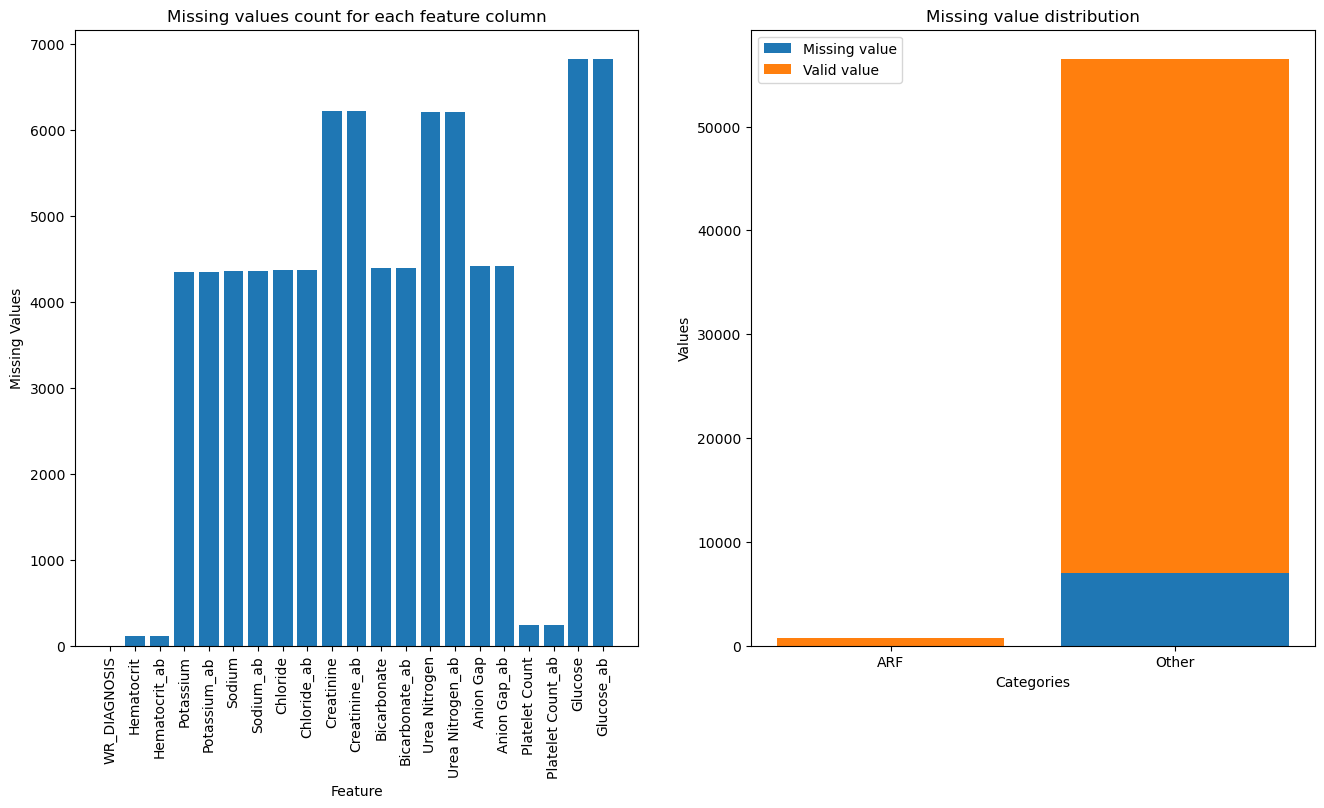

In [5]:
fig, ax = plt.subplots(1,2,figsize = (16,8)) 

temp_list = []
for col in data.columns[3:]:
    temp_list.append(data[col].isna().sum())

ax[0].bar(data.columns[3:],temp_list)
ax[0].set_title("Missing values count for each feature column")
ax[0].set_xlabel("Feature")
ax[0].set_ylabel("Missing Values")
ax[0].tick_params(axis='x',rotation=90)

temp_df = data[data.isna().any(axis=1)]
temp_df_0 = data[~data.isna().any(axis=1)]

# Plot the stacked barchart
temp_value = [len(temp_df[temp_df['WR_DIAGNOSIS']=='ARF']),len(temp_df[temp_df['WR_DIAGNOSIS']=='Other'])]
ax[1].bar(['ARF','Other'], temp_value, label='Missing value')
ax[1].bar(['ARF','Other'], [len(temp_df_0[temp_df_0['WR_DIAGNOSIS']=='ARF']),len(temp_df_0[temp_df_0['WR_DIAGNOSIS']=='Other'])], bottom=temp_value, label='Valid value')

ax[1].set_xlabel('Categories')
ax[1].set_ylabel('Values')
ax[1].set_title('Missing value distribution')
ax[1].legend()
plt.show()

#### From the above two graphs, we can see that the missing values are likely to locate in the same rows, and most of them are from 'other' category, so we can safely remove them without hurting our highly imbalanced minority target ARF group.

In [6]:
#Replace bool with 1/0
#Replace outcome with 1"ARF"/0"Other"
for i in range(0,10):
    data.iloc[:, 4+2*i] = pd.to_numeric(data.iloc[:, 4+2*i], errors='coerce')
data.dropna(inplace = True)
data.replace(True, 1, inplace=True)
data.replace(False, 0, inplace=True)
data.replace('Other', 0, inplace=True)
data.replace('ARF', 1, inplace=True)
data.drop(columns=['SUBJECT_ID', 'DIAGNOSIS'],inplace=True)
data['Outcome'] = data.pop('WR_DIAGNOSIS')
#data.to_csv('ED_Processing_Result.csv',index=False)
data

HADM_ID  Hematocrit  Hematocrit_ab  Potassium  Potassium_ab  Sodium  \
0       165315        35.9              1        4.4             0   140.0   
1       152223        21.9              1        3.9             0   143.0   
2       124321        38.9              1        4.2             0   140.0   
3       161859        40.4              0        4.1             0   139.0   
4       129635        37.9              1        3.3             0   134.0   
...        ...         ...            ...        ...           ...     ...   
57213   105447        29.5              1        4.5             0   149.0   
57214   191113        43.8              0        3.3             0   142.0   
57216   122631        40.5              0        5.6             1   137.0   
57217   170407        29.3              1        3.9             0   144.0   
57218   190264        35.7              1        4.2             0   142.0   

       Sodium_ab  Chloride  Chloride_ab  Creatinine  ...  Bicarbonate_ab  \
0              0     103.0            0         0.6  ...               0   
1              0     112.0            1         0.7  ...               0   
2              0     104.0            0         0.7  ...               0   
3              0     105.0            0         0.9  ...               0   
4              0      95.0            1         1.6  ...               0   
...          ...       ...          ...         ...  ...             ...   
57213          1     109.0            1         0.7  ...               0   
57214          0     124.0            1         0.6  ...               1   
57216          0     105.0            0         1.3  ...               0   
57217          0     111.0            1         0.6  ...               0   
57218          0     106.0            0         0.6  ...               0   

       Urea Nitrogen  Urea Nitrogen_ab  Anion Gap  Anion Gap_ab  \
0               17.0                 0       13.0             0   
1               14.0                 0       12.0             0   
2               16.0                 0       13.0             0   
3               13.0                 0       14.0             0   
4               50.0                 1       19.0             0   
...              ...               ...        ...           ...   
57213           15.0                 0       16.0             0   
57214            9.0                 0        6.0             1   
57216           21.0                 1       15.0             0   
57217            5.0                 1       14.0             0   
57218            9.0                 0       17.0             0   

       Platelet Count  Platelet Count_ab  Glucose  Glucose_ab  Outcome  
0               259.0                  0    102.0           0        0  
1                95.0                  1    128.0           1        0  
2               216.0                  0    141.0           1        0  
3               215.0                  0    100.0           0        0  
4               269.0                  0    378.0           1        0  
...               ...                ...      ...         ...      ...  
57213           184.0                  0    158.0           1        0  
57214           241.0                  0     64.0           1        0  
57216           273.0                  0    131.0           1        0  
57217           272.0                  0    148.0           1        0  
57218           234.0                  0     95.0           0        0  

[50116 rows x 22 columns]

#### Here I processed the data to a more acceptable format for machine learning.
## 1-3: Further process: Imbalance
#### In 1-2, we can also spotted that the data is highly imbalanced, which is problematic. We need to resample them.

In [7]:
temp_X = data.drop(columns=['HADM_ID','Outcome'])
temp_y = data['Outcome']
rus = RandomUnderSampler(random_state=13)
X_resampled, y_resampled = rus.fit_resample(temp_X, temp_y)
X_resampled['Outcome'] = y_resampled
data_resampled = X_resampled
data_resampled

Hematocrit  Hematocrit_ab  Potassium  Potassium_ab  Sodium  Sodium_ab  \
0           38.0              1        4.1             0   140.0          0   
1           25.0              1        5.5             1   135.0          0   
2           29.3              1        4.0             0   142.0          0   
3           40.8              0        4.2             0   142.0          0   
4           33.5              1        5.0             0   135.0          0   
...          ...            ...        ...           ...     ...        ...   
1429        41.0              0        9.2             1   133.0          0   
1430        54.1              1        4.5             0   140.0          0   
1431        30.1              1        3.9             0   142.0          0   
1432        30.5              1        5.7             1   142.0          0   
1433        41.9              0        4.7             0   134.0          0   

      Chloride  Chloride_ab  Creatinine  Creatinine_ab  ...  Bicarbonate_ab  \
0        107.0            0         1.9              1  ...               0   
1        110.0            1         2.1              1  ...               1   
2        104.0            0         0.7              0  ...               0   
3        104.0            0         8.8              1  ...               1   
4        104.0            0         0.7              0  ...               0   
...        ...          ...         ...            ...  ...             ...   
1429     107.0            0         0.7              0  ...               1   
1430     107.0            0         1.0              0  ...               1   
1431      99.0            0         0.4              0  ...               1   
1432     104.0            0         0.7              0  ...               0   
1433     106.0            0         1.0              0  ...               1   

      Urea Nitrogen  Urea Nitrogen_ab  Anion Gap  Anion Gap_ab  \
0              27.0                 1       12.0             0   
1              47.0                 1       22.0             1   
2              10.0                 0       10.0             0   
3             117.0                 1       24.0             1   
4              17.0                 0       12.0             0   
...             ...               ...        ...           ...   
1429            6.0                 0       15.0             0   
1430           27.0                 1       18.0             0   
1431           32.0                 1        7.0             1   
1432           49.0                 1       18.0             0   
1433           16.0                 0       13.0             0   

      Platelet Count  Platelet Count_ab  Glucose  Glucose_ab  Outcome  
0              192.0                  0     89.0           0        0  
1              158.0                  0    173.0           1        0  
2              255.0                  0    121.0           1        0  
3               67.0                  1    273.0           1        0  
4              305.0                  0    164.0           1        0  
...              ...                ...      ...         ...      ...  
1429           479.0                  1    108.0           1        1  
1430           280.0                  0    135.0           1        1  
1431           259.0                  0    145.0           1        1  
1432           582.0                  1    169.0           1        1  
1433           233.0                  0    180.0           1        1  

[1434 rows x 21 columns]

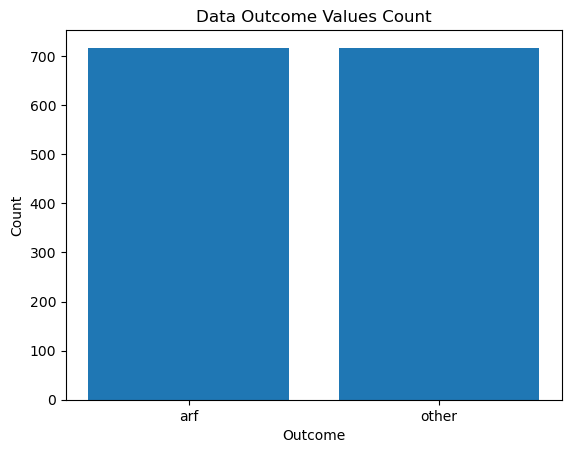

In [8]:
plt.bar(['arf','other'],data_resampled['Outcome'].value_counts())
plt.title("Data Outcome Values Count")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.show()

#### With this we can say our data set is balanced.
#### Again in real machine learning model training processes there should have been more steps to go through, including PCA, outliers detection&removal, etc, but the current data is already sufficient to train an acceptable, for the sake of being prompt.

# Section 2: Model and Application
## 2-0: Model training

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data_resampled.drop(columns=['Outcome']), data_resampled.Outcome.to_list(), test_size=0.2, random_state=13)
model = make_pipeline(MinMaxScaler(), MLPClassifier(solver = 'sgd', activation = 'relu', max_iter = 2000, learning_rate='adaptive', hidden_layer_sizes = (100,75,50,25,5,1),random_state = 13))
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.6306620209059234

#### The accuracy is 63%, which is far from being good but is expected because we sacrificed some optimization processes for the sake of being prompt.

## 2-1: Classification & Prediction

In [10]:
sample = X_test.reset_index().sample(n=1, random_state=13)
sample

index  Hematocrit  Hematocrit_ab  Potassium  Potassium_ab  Sodium  \
127    899        26.0              1        3.8             0   149.0   

     Sodium_ab  Chloride  Chloride_ab  Creatinine  ...  Bicarbonate  \
127          1     115.0            1         1.0  ...         24.0   

     Bicarbonate_ab  Urea Nitrogen  Urea Nitrogen_ab  Anion Gap  Anion Gap_ab  \
127               0           27.0                 1       14.0             0   

     Platelet Count  Platelet Count_ab  Glucose  Glucose_ab  
127           251.0                  0    282.0           1  

[1 rows x 21 columns]

In [11]:
y_pred = model.predict(sample.drop(columns=['index']))
print("Prediction:", y_pred)
print("Actual:",y_test[127])

Prediction: [1]
Actual: 1


#### The sample is predicted/classified as 1:ARF, which is correct.
## 2-2: Inference

  0%|          | 0/287 [00:00<?, ?it/s]

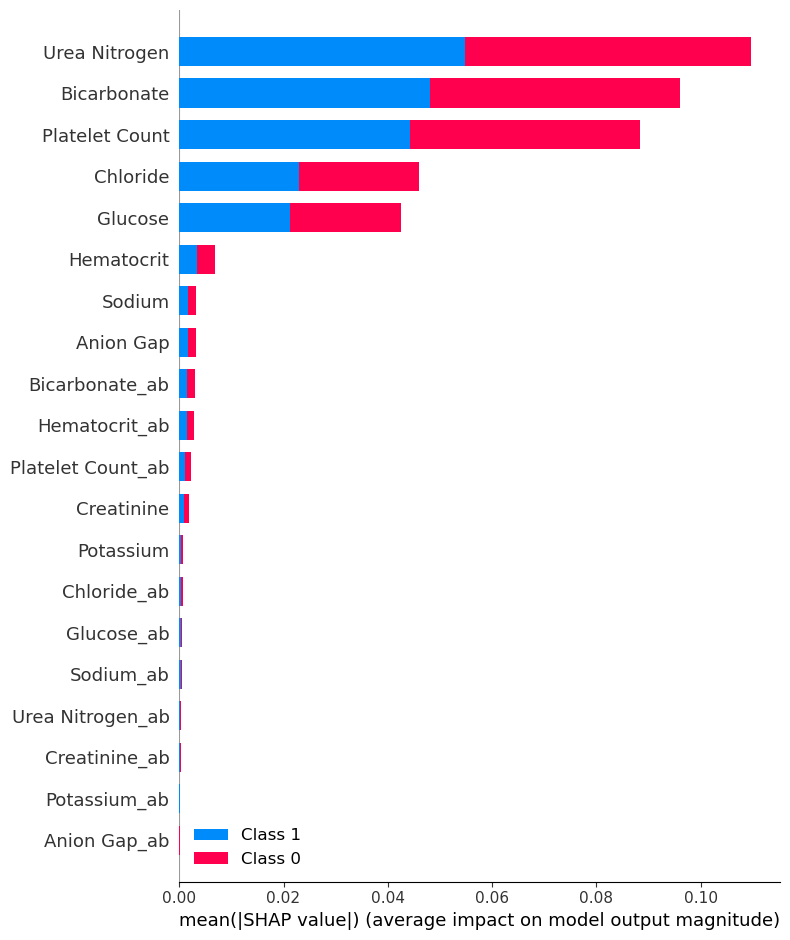

In [12]:
test_model =  MLPClassifier(solver = 'sgd', activation = 'relu', max_iter = 2000, learning_rate='adaptive', hidden_layer_sizes = (100,75,50,25,5,1),random_state = 13).fit(X_train,y_train)
X_sample = shap.utils.sample(X_test, 10)
explainer = shap.KernelExplainer(test_model.predict_proba, feature_names=X_train.columns, data=X_sample)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_sample, feature_names=X_train.columns)

#### This explains the model's ability of interence.
## 2-3: Clustering and anomoly detection
#### Though neural networks, backed up by the idea of ensemble learning, have been shown to be capable of doing clustering and thus anomaly detection, in this prompt please allow me to demonstrate general unsupervised clustering models as models which are more suitable for our project scale. 

The figure layout has changed to tight


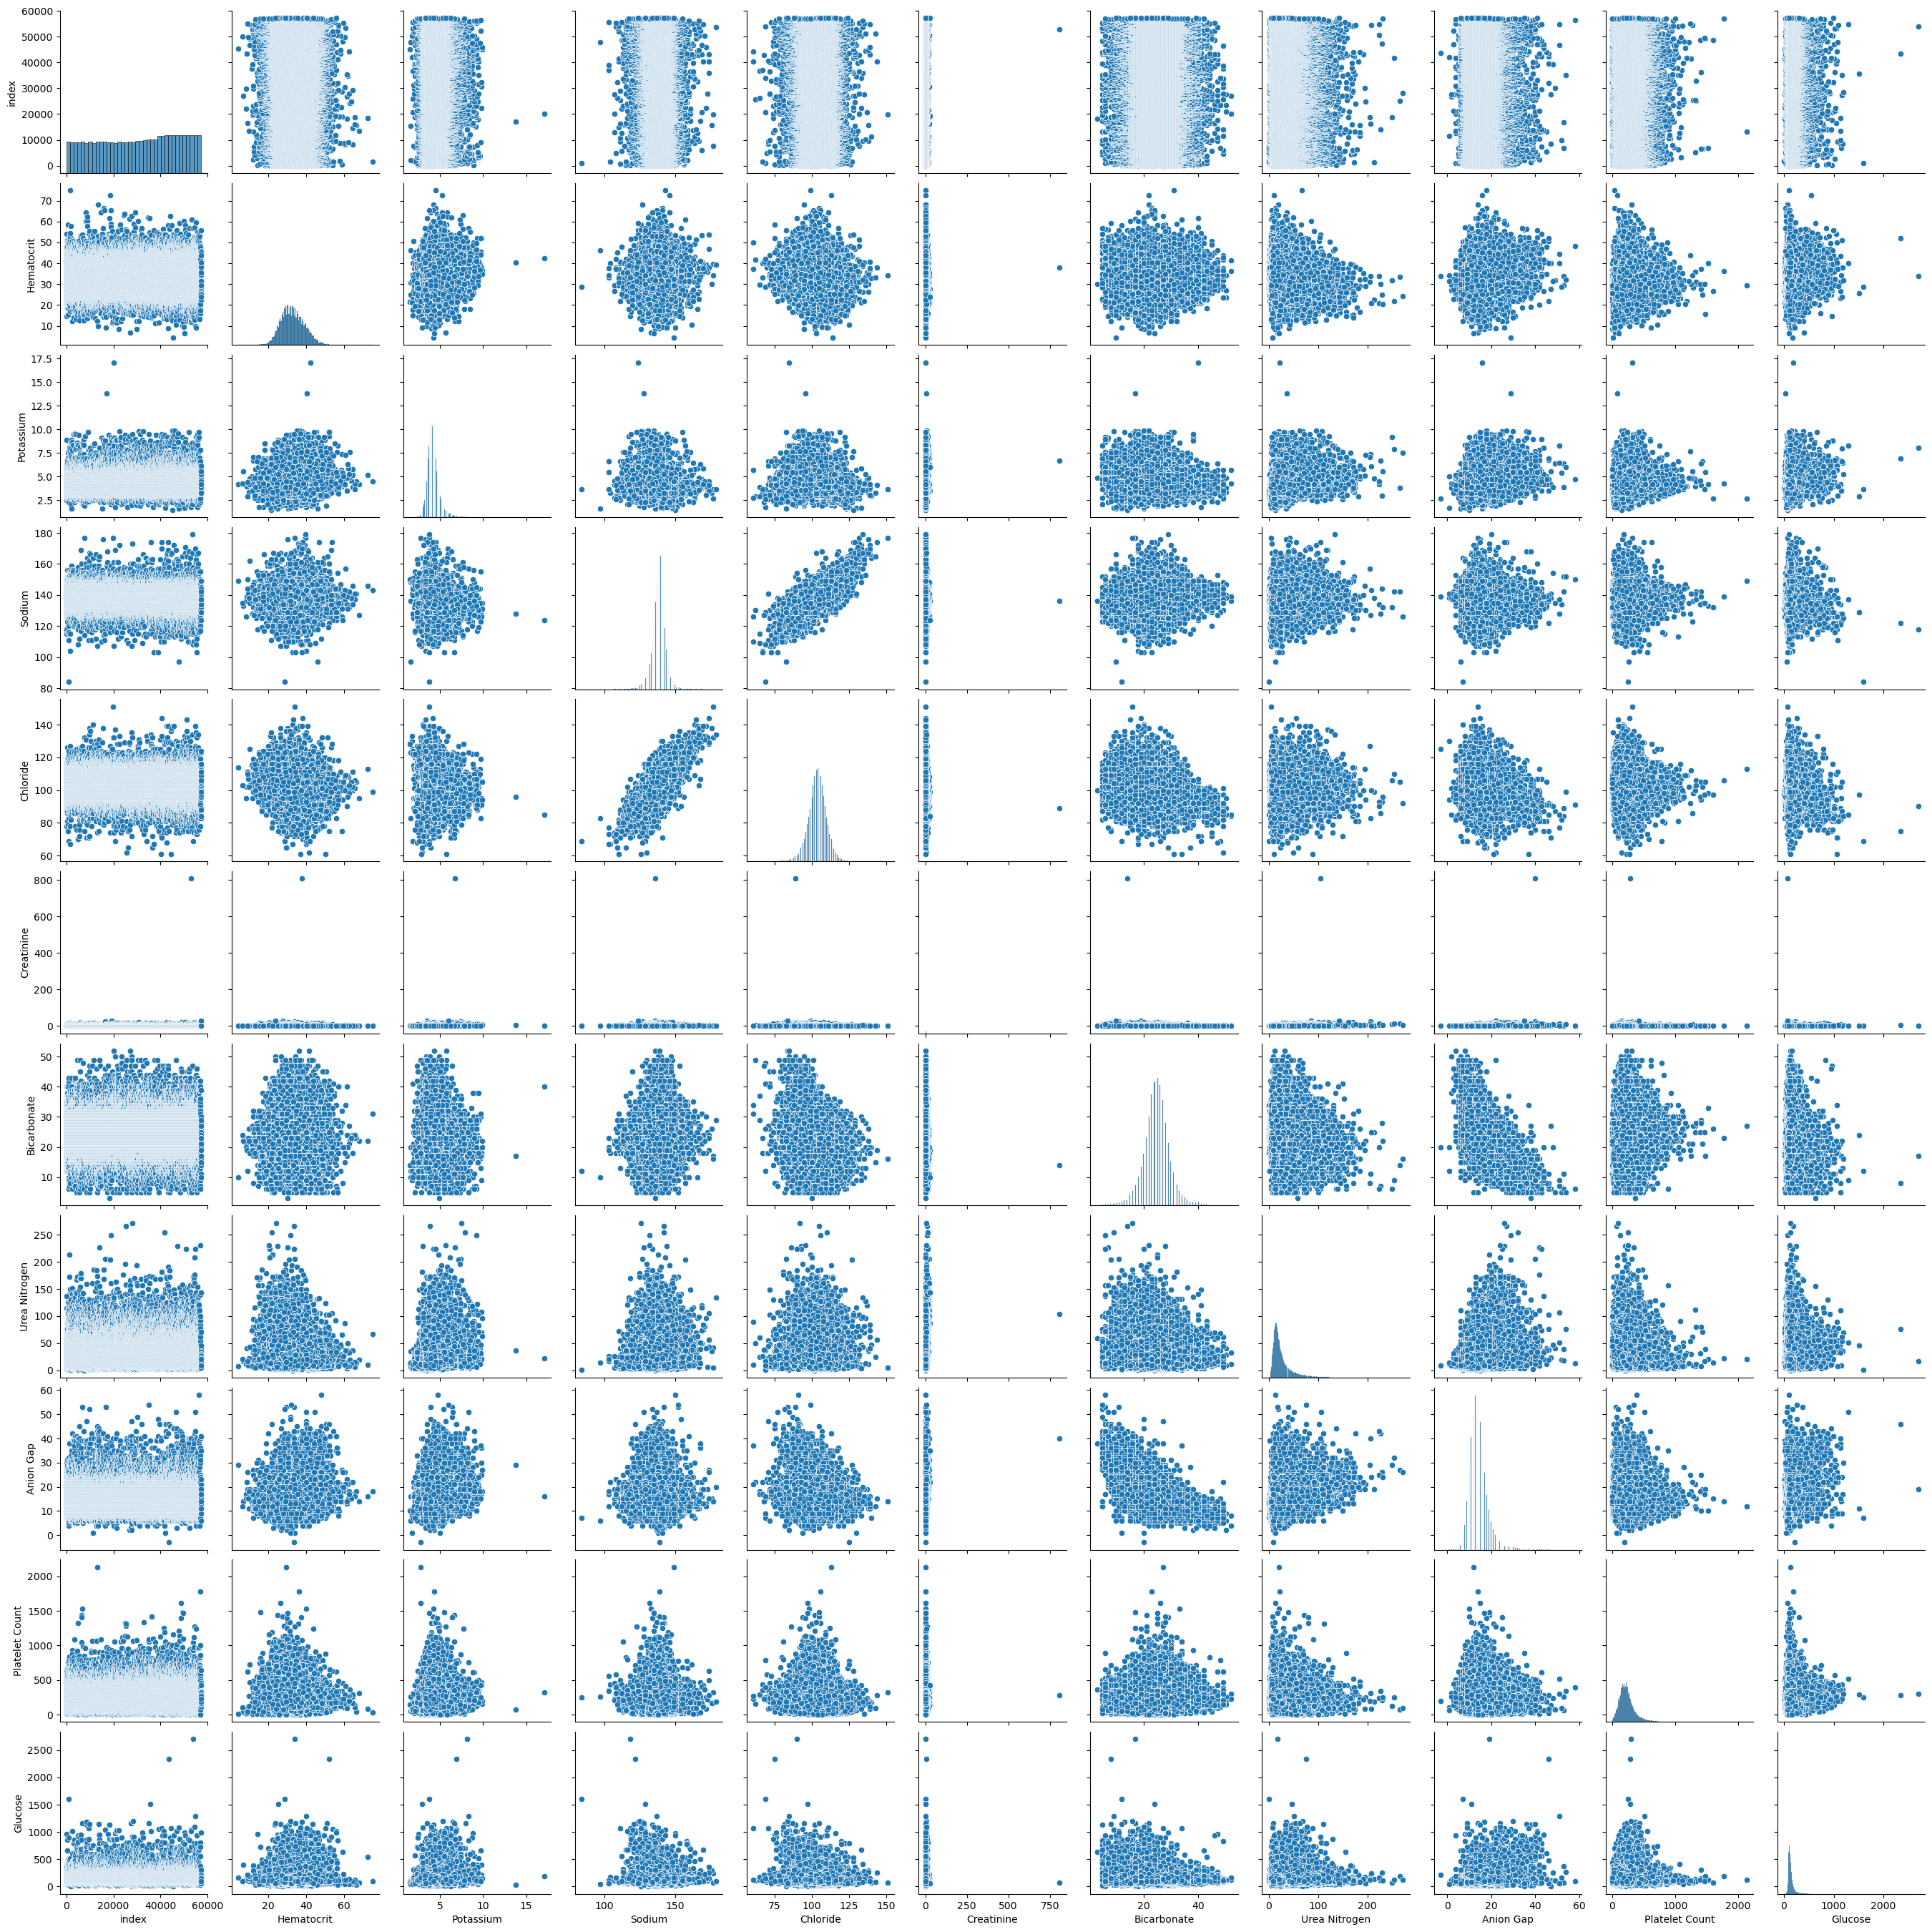

In [13]:
temp_list = []
for i in range(0,10):
    temp_list.append(data.columns[2*i+1])
temp_list.append('Outcome')
temp_data = data[temp_list]
temp_data.reset_index(inplace=True)

sns.pairplot(temp_data, vars=temp_data.columns[:-1])

#### With this we can see there exists multiple outliers, and we will need to use clustering to detect them

In [30]:
c_model = DBSCAN(eps=4.2, min_samples=3).fit(StandardScaler().fit_transform(data.drop(columns=['HADM_ID','Outcome'])))

In [33]:
temp_data['Outlier'] = np.zeros(len(temp_data))
for row in np.where(c_model.labels_ == -1)[0]:
    temp_data.at[row, 'Outlier'] = 1
temp_data['Outlier'].value_counts()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Outlier
0.0    49919
1.0      197
Name: count, dtype: int64

The figure layout has changed to tight


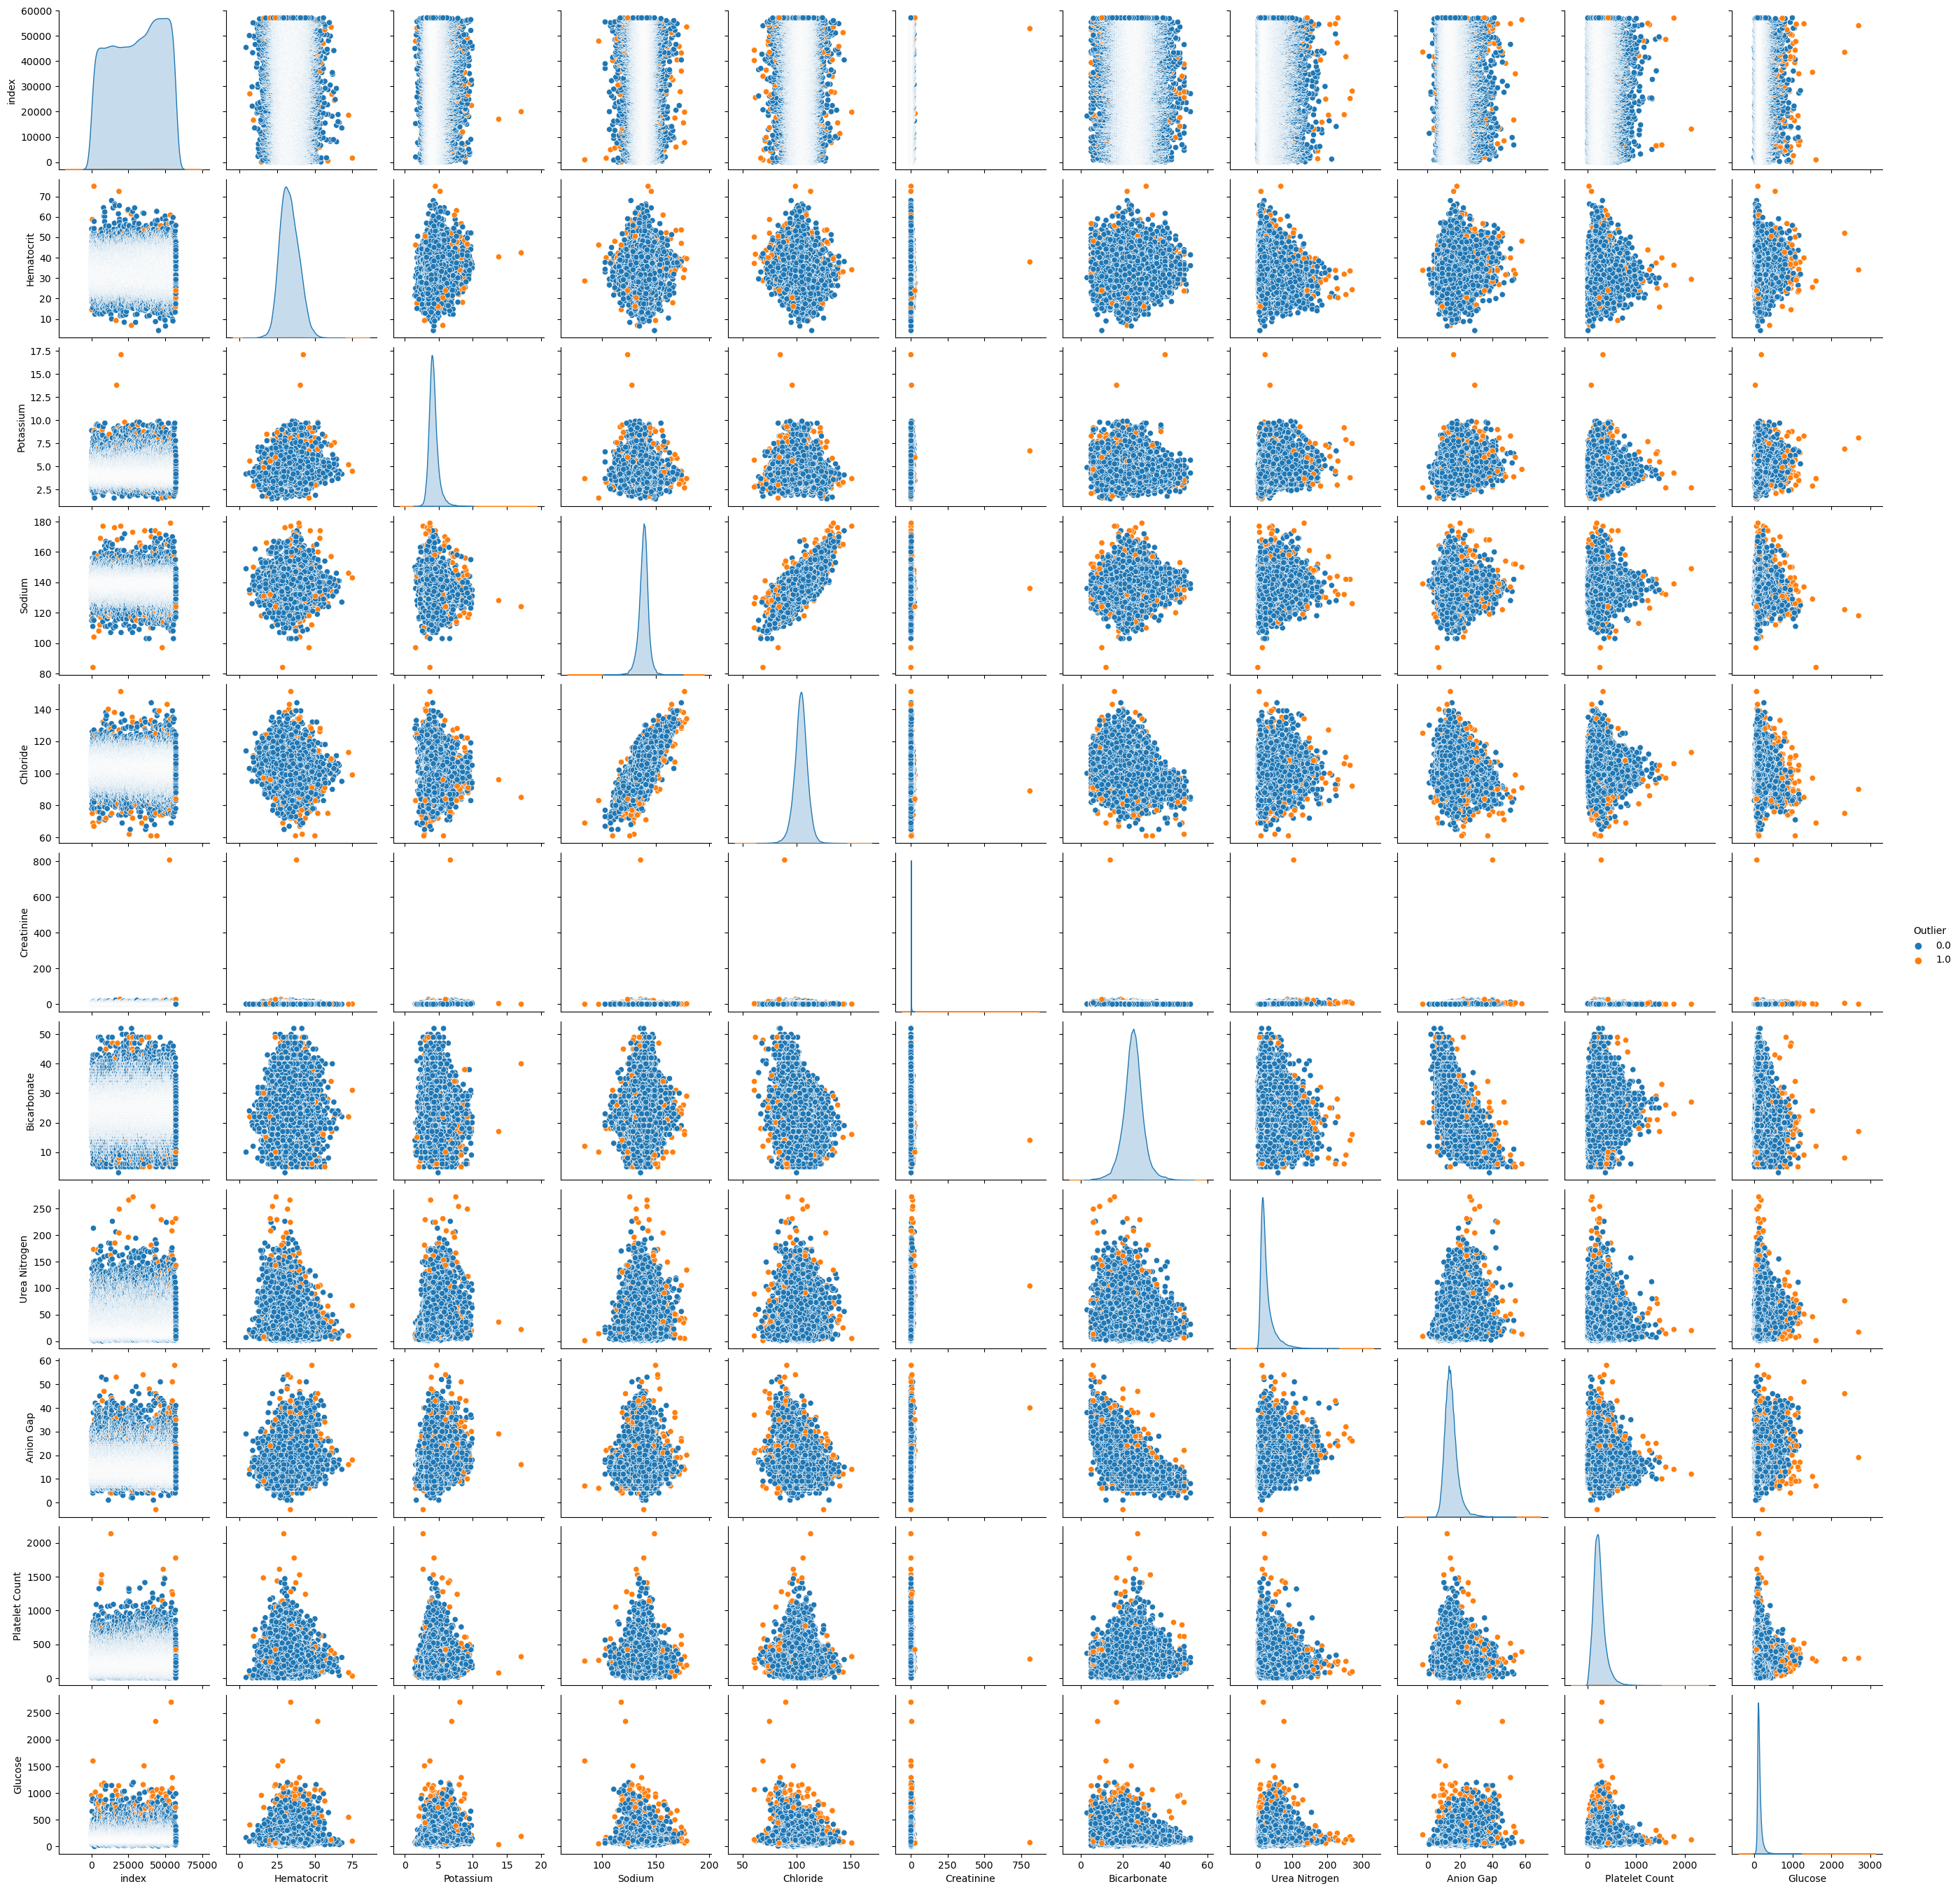

In [34]:
sns.pairplot(temp_data, vars=temp_data.columns[:-2], hue="Outlier")

#### Now the outliers in each dimension are spotted by clustering and are ready to be removed.
### With this we have demonstrated all the ML funtions mentioned in the prompt topic guidelines.
## Thank you!